In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
logger_mode = 'debug'

def log(*args):
    if logger_mode == 'debug':
        print(*args)

In [3]:
class Board(object):
    """
    The environment for the reinforcement learning project.
    
    It should:
        - Have a matrix of size = NxN (which is basically N rows and N columns where N is a positive integer, greater than 0)
            - I have taken N as 3, but that is not necessary.
        - Initialize the matrix with zeroes.
            - The values in the matrix will be represented by integers: 0, 1, 2.
                - 0: empty cell represented by ' '.
                - 1: cell occupied by symbol 'O'.
                - 2: cell occupied by symbol 'X'.
            - 'X' or 'O' can be chosen by the player at initialization step by providing a choice in `player_sym`, defaults to 'x'
            - The other symbol will be chosen for the bot.
        - Have a property of winner, initialized by None.
        - Have a method to reset the board.
        - Have a method to represent the board in a human friendly form using 'X', 'O' and ' ' instead of the respective integers 2, 1, and 0.
        - Have a method which lets a user play by plotting a symbol of 'X' or 'O' only! anywhere within the matrix.
        - Calculates if there is a winner after each symbol is plotted. 
            - A win is defined by any row, column or diagonal being filled with the same symbol, with the symbol as the winner.
        - If there is a winner, prints a message for the same.
    """
    def __init__(self, n=3, player_sym='x'):
        """
        Constructor of the Board class, creates board objects.
        
        - n(default=3) int: The number of rows and columns in the tic-tac-toe board.
        - player_sym(default='x') str: The symbol chosen by a human player.
        """
        self.board = None
        self.reset_board(n)
        self.stale = False
        # Initalize the board

        self.sym_o = {
            'mark': 'O',
            'value': 1
        }
        # Setup the 'O' symbol

        self.sym_x = {
            'mark': 'X',
            'value': 2
        }
        # Setup the 'X' symbol

        self.sym_empty = {
            'mark': ' ',
            'value': 0
        }
        # Setup the default ' ' Symbol

        self.player_sym, self.bot_sym = (self.sym_x, self.sym_o) \
                                        if player_sym.lower() == 'x' \
                                        else (self.sym_o, self.sym_x)
        # Ensure different symbols are assigned to the bot and the player.

        self.winner = None
        # Initialize the winner as None

    def reset_board(self, n=3):
        """
        params:
        
        - n(default=3): int: The number of rows and columns in the tic-tac-toe board.
        Clear the board when the game is to be restarted or a new game has to be started.
        """
        self.board = np.zeros((n, n)).astype(int)
        self.winner = None
        
    def draw_char_for_item(self, item):
        """
        Returns the string mapping of the integers in the matrix 
        which can be understood by, but is not equal to: 
        {
            0: ' ',
            1: 'O',
            2: 'X'
        }
        (The exact mapping is present in the constructor)
        
        params:
        
        - item int: One of (1, 2, 0) representing the mark of the player, bot or empty.
        return: str
        """
        if item == self.sym_x.get('value'):
            # If item = 2 (value of symbol x, return mark of symbol x viz: 'X')
            return self.sym_x.get('mark')
        elif item == self.sym_o.get('value'):
            # If item = 1 (value of symbol o, return mark of symbol o viz: 'O')
            return self.sym_o.get('mark')
        else:
            # Otherwise the cell must be empty, as only 1, 2 have 'O','X' mapped onto them.
            return self.sym_empty.get('mark')

    def draw_board(self):
        """
        Prints a human friendly representation of the tic-tac-toe board
        """
        elements_in_board = self.board.size
        # Calculate the elements in the board

        items = [
            self.draw_char_for_item(self.board.item(item_idx)) 
            for item_idx in range(elements_in_board)
        ]
        # For each integer cell/element in the matrix, find the character mapped to it
        # and store in a list.
        board = """
             {} | {} | {}
            -----------
             {} | {} | {}
            -----------
             {} | {} | {}
        """.format(*items)
        # The *items expand to N arguments where N is the number of elements in `items`,
        # which is equal to the number of elements in the matrix, hence the string equivalent 
        # of the board
        print(board)
        
    def have_same_val(self, axis, item, item_x, item_y):
        """
        Oh boy! without the documentation this would be just 12-14 lines of code.
        
        Checks if a row(if axis = 0) of the board matrix has same values throughout.
                                    or
        Checks if a column(if axis = 1) of the board matrix has same values throughout.
        
        This is useful to check if a row or column is filled up by the symbol which was added the latest.
        
        params:
        
        - axis int: The direction along which operations are to be performed. Can have a value of 0 or 1 only.
            - 0 means row
            - 1 means column
        - item_x int: The row of the matrix in which item has been inserted.
        - item_y int: The column of the matrix in which the item has been inserted.
        - item int: The latest integer inserted into the matrix at row-index = item_x, and column-index = item_y. 
        """
        max_limit, _ = self.board.shape
        # Get the number of rows in the board.

        result = True
        # Optimistic approach, assume the result to be true, 
        # unless proven wrong in the further steps.
        
        row_idx = col_idx = 0
        # set row_idx and col_idx iteration variables as 0
        # they don't get used much, they are present for code readability.

        main_idx, fixed_idx, ignore_idx = (col_idx, item_x, item_y) \
                                            if axis == 0 \
                                            else (row_idx, item_y, item_x)
        # main_idx: Update this index each iteration of the loop.
        # fixed_idx: Don't modify this index ever.
        # ignore_idx: this is the index of the inserted element 
        #              which doesn't need to be evaluated, so ignore.
        # The if-else ensures weather to increment the row index 
        # or the column index according to the value of the axis.
        
        while main_idx < max_limit:
            # If the main_idx which starts at 0 is less than number of rows/cols in matrix.
            if main_idx != ignore_idx:
                # And main_idx is not equal to the index of the latest item inserted (ignore_idx)
                # because for a fixed_index if we compare main_idx and ignore_idx it would give us the 
                # latest element added, which will be equal to itself.
                # Learning algorithms are costly, ain't nobady got time fo that!

                board_item = self.board[fixed_idx][main_idx] \
                    if axis == 0 \
                    else self.board[main_idx][fixed_idx]
                # find the item(board_item) in the matrix 
                # corresponding to main_idx and the fixed_index.
                # It should be an element in the same row or column depending on the axis.
                
                if board_item != item or board_item == 0:
                    # If the board_item found is not equal to the latest item added
                    # or if the board item is 0, which is still not marked by bot or player,
                    # result is false as the function didn't find all 
                    # values to be same across the row, or column.
                    # and exit the loop because a single-mismatch is sufficient 
                    # to confirm that all elements are not same.
                    result = False
                    break
            main_idx += 1
        return result
    
    def left_diagonal_has_same_values(self, item, item_x, item_y):
        """
        params
        
        - item_x int: The row of the matrix in which item has been inserted.
        - item_y int: The column of the matrix in which the item has been inserted.
        - item int: The latest integer inserted into the matrix at row-index = item_x, and column-index = item_y. 
        """
        i = j = 0
        # set i, j to 0
        
        result = True
        # Optimistic approach, assume the result to be true, 
        # unless proven wrong in the further steps.
        
        max_limit, _ = self.board.shape
        # Get the number of rows in the board.
        
        while i < max_limit:
            # The row index i is sufficient as i and j are incremented 
            # by same factor resulting in same values (Either would do)
            if i != item_x:
                # Avoid checking for the latest item added as that's what we are comparing with
                if self.board[i][j] != item or self.board[i][j] == 0:
                    # If the board_item found is not equal to the latest item added
                    # result is false as the function didn't find all 
                    # values to be same across the row, or column.
                    # and exit the loop because a single-mismatch is sufficient 
                    # to confirm that all elements are not same.
                    result = False
                    break
            i += 1
            j += 1
        return result

    def right_diagonal_has_same_values(self, item, item_x, item_y):
        """
        params
        
        - item_x int: The row of the matrix in which item has been inserted.
        - item_y int: The column of the matrix in which the item has been inserted.
        - item int: The latest integer inserted into the matrix at row-index = item_x, and column-index = item_y. 
        """
        result = True
        max_limit, _ = self.board.shape
        i = 0
        j = max_limit - 1
        while i < max_limit:
            # The row index i is sufficient as i and j are incremented 
            # by same factor resulting in same values (Either would do)
            if i != item_x:
                # Avoid checking for the latest item added as that's what we are comparing with
                if self.board[i][j] != item or self.board[i][j] == 0:
                    # If the board_item found is not equal to the latest item added
                    # result is false as the function didn't find all 
                    # values to be same across the row, or column.
                    # and exit the loop because a single-mismatch is sufficient 
                    # to confirm that all elements are not same.
                    result = False
                    break
            i += 1
            j -= 1
        return result

    def cols_have_same_values(self, item, item_x, item_y):
        """
        Check if any of the columns have same values
        
        params
        
        - item_x int: The row of the matrix in which item has been inserted.
        - item_y int: The column of the matrix in which the item has been inserted.
        - item int: The latest integer inserted into the matrix at row-index = item_x, and column-index = item_y. 
        """
        axis = 1
        return self.have_same_val(axis, item, item_x, item_y)

    def rows_have_same_values(self, item, item_x, item_y):
        """
        Check if any of the rows have same values
        
        params
        
        - item_x int: The row of the matrix in which item has been inserted.
        - item_y int: The column of the matrix in which the item has been inserted.
        - item int: The latest integer inserted into the matrix at row-index = item_x, and column-index = item_y. 
        """
        axis = 0
        return self.have_same_val(axis, item, item_x, item_y)
    
    def element_diagonal_has_same_value(self, item, item_x, item_y):
        """
        Check if any of the diagonals have same values
        
        params
        
        - item_x int: The row of the matrix in which item has been inserted.
        - item_y int: The column of the matrix in which the item has been inserted.
        - item int: The latest integer inserted into the matrix at row-index = item_x, and column-index = item_y. 
        """
        max_limit, _ = self.board.shape
        if item_x == item_y and item_x + item_y == max_limit - 1:
            return self.left_diagonal_has_same_values(item, item_x, item_y) or \
            self.right_diagonal_has_same_values(item, item_x, item_y)
        
        if item_x == item_y:
            # elements on the left diagonal have same row and column value.
            return self.left_diagonal_has_same_values(item, item_x, item_y)

        if item_x + item_y == max_limit - 1:
            # elements on the right diagonal have sum of the row and column value as the same number.
            return self.right_diagonal_has_same_values(item, item_x, item_y)
        # Else, it is not either of the diagonals
        return False
    
    def is_game_over(self, player, item, item_x, item_y):
        """
        Check if the game is over, which is defined by a row, column or diagonal having 
        the same values as the latest inserted integer `item`.
        
        params
        
        - item_x int: The row of the matrix in which item has been inserted.
        - item_y int: The column of the matrix in which the item has been inserted.
        - item int: The latest integer inserted into the matrix at row-index = item_x, and column-index = item_y. 
        """
        return self.cols_have_same_values(item, item_x, item_y) or \
                    self.rows_have_same_values(item, item_x, item_y) or \
                    self.element_diagonal_has_same_value(item, item_x, item_y)

    def is_winning_move(self, player, item, item_x, item_y):
        """
        Check if the last move was a winning move, which is defined by a row, column or diagonal having 
        the same values as the latest inserted integer `item`.
        
        params
        
        - item_x int: The row of the matrix in which item has been inserted.
        - item_y int: The column of the matrix in which the item has been inserted.
        - item int: The latest integer inserted into the matrix at row-index = item_x, and column-index = item_y. 
        """
        if self.is_game_over(player, item, item_x, item_y):
            self.winner = player
            return True
        return False
    
    def is_stale(self):
        """
        Checks if there is no vacant space on the board
        """
        x, y = np.where(self.board == 0)
        if len(x) == 0 and len(y) == 0:
            self.stale = True
        log('is game stale? ', self.stale)
        return self.stale
            
    
    def player_move(self, input_symbol, item_x, item_y):
        """
        The method which facilitates insertion of values into the board matrix.
        
        params:
        
        - input_symbol: 'X' or 'O'
        - item_x int: The row of the matrix in which item has been inserted.
        - item_y int: The column of the matrix in which the item has been inserted.
        """
        symbol = None
        
        if input_symbol == self.sym_o.get('mark'):
            # If 'O' was inserted
            symbol = self.sym_o
        
        elif input_symbol == self.sym_x.get('mark'):
            # If 'X' was inserted
            symbol = self.sym_x

        else:
            # invalid symbol
            return
        if self.board[item_x][item_y] == 0:
            self.board[item_x][item_y] = symbol.get('value')
            # insert the integer corresponding to the symbol in to the matrix.

            self.draw_board()
            # Show the board in a human friendly format for evaluation.

            if self.is_winning_move(symbol.get('mark'), symbol.get('value'), item_x, item_y):
                # If this move was a winning move, declare the symbol as the winner.
                print('Winner is: {}'.format(self.winner))
                return self.winner
            elif self.is_stale():
                print('Draw')
                return 'draw'
        
    def play(self, item_x, item_y):
        """
        The method exposed to a human user
        facilitates insertion of values into the board matrix.
        
        params:
        
        - input_symbol: 'X' or 'O'
        - item_x int: The row of the matrix in which item has been inserted.
        - item_y int: The column of the matrix in which the item has been inserted.
        """
        max_limit, _ = self.board.shape
        if item_x > max_limit - 1 or item_y > max_limit:
            # If the row, column values dont' exist in the board matrix. 
            # Exit without inserting it into the board.
            return
        self.player_move(self.player_sym.get('mark'), item_x, item_y)
        
    def bot_play(self, item_x, item_y):
        """
        The method exposed to a bot
        facilitates insertion of values into the board matrix.
        
        params:
        
        - input_symbol: 'X' or 'O'
        - item_x int: The row of the matrix in which item has been inserted.
        - item_y int: The column of the matrix in which the item has been inserted.
        """
        max_limit, _ = self.board.shape
        if item_x > max_limit - 1 or item_y > max_limit:
            return
        self.player_move(self.bot_sym.get('mark'), item_x, item_y)

In [4]:
class Agent(object):
    def __init__(self, exploration_rate=0.33, learning_rate=0.5, discount_factor=0.01):
        """
        An agent is a problem solver. 
        It should perform actions like:
            - plotting a symbol on the tic-tac-toe board if it is vacant.
            - Remember which states are more profitable than the others.
            - Explore better states
            - Exploit for maximum profit
        
        params:
        - exploration_rate: A floating point number < 1 
                which defines the agents probability to explore.
        - learning_rate: Used for assessing the value of intermediate 
                states during temporal difference learning.
        - discount_factor: The factor by which a reward must be reduced 
                to be passed on for intermediate states
        """
        self.states = {}
        # The list of states, a linear representation of the 3x3 tic tac toe board
        self.state_order = []
        # The order in which the agent progressed through states to be able to 
        # assign discounted rewards to older states.
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate

    @staticmethod
    def serialize_board(board):
        """
        convert the matrix 
        
            [
                [1, 2, 3],
                [4, 5, 6],
                [7, 8, 9],
            ]
            
            to the form: "123456789" i.e. flatten and stringify
        """
        serialized_board = board.flatten()
        return ''.join([str(i) for i in serialized_board.flatten().tolist()])

    def get_serious(self):
        """
        Quit exploring states and start exploiting
        Use this if you want to play with the agent.
        """
        self.exploration_rate = 0
    
    def learn_by_temporal_difference(self, reward, new_state_key, state_key):
        """
        Implementation of the temporal difference formula.
        https://en.wikipedia.org/wiki/Temporal_difference_learning
        https://detailed.af/reinforcement/
        """
        old_state = self.states.get(state_key, np.zeros((3,3)))
        return self.learning_rate * ((reward * self.states[new_state_key]) - old_state)

    def set_state(self, old_board, action):
        """
        Store the action performed for a given state
        """
        state_key = Agent.serialize_board(old_board)
        self.state_order.append((state_key, action))

    def on_reward(self, reward):
        """
        Assign rewards to actions performed on intermediate states.
        """
        if len(self.state_order) == 0:
            return None
        new_state_key, new_action = self.state_order.pop()
        # get the latest state and the action performed that led to the reward

        self.states[new_state_key] = np.zeros((3,3))
        # initialize the value with a zero matrix

        self.states[new_state_key].itemset(new_action, reward)
        # Assign the reward to this state
        
        while self.state_order:
            # while there is a stack of states (that were caused by actions performed)

            state_key, action = self.state_order.pop()
            # get the state and action performed on it
            
            reward *= self.discount_factor
            # Reduce the original reward (self.discount_factor is a number < 1)
            
            # Implementation of the value function
            if state_key in self.states:
                reward += self.learn_by_temporal_difference(reward, new_state_key, state_key).item(new_action)
                # If this state was encountered due to a different experiment, increase its previous value
                self.states[state_key].itemset(action, reward)
            else:
                self.states[state_key] = np.zeros((3,3))
                reward = self.learn_by_temporal_difference(reward, new_state_key, state_key).item(new_action)
                self.states[state_key].itemset(action, reward)
                # If this state was not encountered before, assign it the discounted reward as its value                
            new_state_key = state_key
            new_action = action
            
    def select_move(self, board):
        """
        Choose from exploration and exploitation.
        Epsilon greedy implementation for policy.
        http://home.deib.polimi.it/restelli/MyWebSite/pdf/rl5.pdf
        http://tokic.com/www/tokicm/publikationen/papers/AdaptiveEpsilonGreedyExploration.pdf
        """
        explore_message = 'No experience for this state: explore'
        state_key = Agent.serialize_board(board)
        exploration = np.random.random() < self.exploration_rate
        log(explore_message if exploration or state_key not in self.states else 'exploit')
        action = self.explore_board(board) \
                    if exploration or state_key not in self.states \
                    else self.exploit_board(state_key)
        log('Choose cell', action)
        self.set_state(board, action)
        return action

    def explore_board(self, board):
        """
        Find an empty cell from the board
        """
        zero_x, zero_y = np.where(board == 0)
        vacant_cells = [(x, y) for x, y in zip(zero_x, zero_y)]
        randomly_selected_vacant_cell = np.random.choice(len(vacant_cells))
        return vacant_cells[randomly_selected_vacant_cell]
        
    def exploit_board(self, state_key):
        """
        Find the best action for the given state
        """
        state_values = self.states[state_key]
        # For the current state get the matrix of accumulated rewards
        print('State rewards')
        print(state_values)
        
        best_actions_x, best_actions_y = np.where(state_values == state_values.max())
        # Find the coordinates which correspond to highest reward
        
        best_value_indices = [(x, y) for x,y in zip(best_actions_x, best_actions_y)]
        select_index = np.random.choice(len(best_value_indices))
        return best_value_indices[select_index]

In [5]:
bot1_sym = 'O'
bot2_sym = 'X'

def optimize_bot(game, bot1, bot2):
    """
    Punish or Reward the bot with respect to the agent that wins the game
    """
    if game.winner == bot1_sym:
        bot1.on_reward(1)
        # reward
        bot2.on_reward(-1)
        # punishment
    elif game.winner == bot2_sym:
        bot1.on_reward(-1)
        bot2.on_reward(1) 
    
def train(epochs, bot1, bot2):
    bots = [{
        'mdl': bot1,
        'name': 'bot1',
        'sym': bot1_sym,
        'wins': 0
    }, {
        'mdl': bot2,
        'name': 'bot2',
        'sym': bot2_sym,
        'wins': 0        
    }]

    win_trace = pd.DataFrame(data=np.zeros((epochs, 2)), columns=['bot1', 'bot2'])
    for i in range(epochs):
        print('-' * 100)
        print('epoch: {}'.format(i + 1))
        game = Board()
        while not game.stale and not game.winner:
            # Exit if the board is full
            for bot in bots:
                winner = game.player_move(bot['sym'], *bot['mdl'].select_move(game.board))
                log('winner found:', winner)
                if winner:
                    optimize_bot(game, bot1, bot2)
                    bot['wins'] += 1
                    win_trace.set_value(i, bot['name'], 1)
                    break
                    win_trace[i] = 2
                elif winner == 'draw':
                    break
    return win_trace, bots[0]['wins'], bots[1]['wins']

In [6]:
bot1 = Agent()
bot2 = Agent()
epochs = 100
win_trace, bot1_wins, bot2_wins = train(epochs, bot1, bot2)

----------------------------------------------------------------------------------------------------
epoch: 1
No experience for this state: explore
Choose cell (0, 2)

               |   | O
            -----------
               |   |  
            -----------
               |   |  
        
is game stale?  False
winner found: None
No experience for this state: explore
Choose cell (1, 1)

               |   | O
            -----------
               | X |  
            -----------
               |   |  
        
is game stale?  False
winner found: None
No experience for this state: explore
Choose cell (1, 2)

               |   | O
            -----------
               | X | O
            -----------
               |   |  
        
is game stale?  False
winner found: None
No experience for this state: explore
Choose cell (0, 1)

               | X | O
            -----------
               | X | O
            -----------
               |   |  
        
is game stale?  False
winner fo


             X |   |  
            -----------
             X | O | O
            -----------
             O | O |  
        
is game stale?  False
winner found: None
No experience for this state: explore
Choose cell (0, 2)

             X |   | X
            -----------
             X | O | O
            -----------
             O | O |  
        
is game stale?  False
winner found: None
No experience for this state: explore
Choose cell (2, 2)

             X |   | X
            -----------
             X | O | O
            -----------
             O | O | O
        
Winner is: O
winner found: O
----------------------------------------------------------------------------------------------------
epoch: 22
exploit
State rewards
[[ 0.00000000e+00 -4.98737562e-07 -4.98737562e-07]
 [-4.98737562e-07 -4.98737562e-07  0.00000000e+00]
 [ 0.00000000e+00  1.25000008e-11  0.00000000e+00]]
Choose cell (2, 1)

               |   |  
            -----------
               |   |  
            -----

No experience for this state: explore
Choose cell (0, 2)

               |   | X
            -----------
               | X |  
            -----------
             O |   | O
        
is game stale?  False
winner found: None
No experience for this state: explore
Choose cell (0, 1)

               | O | X
            -----------
               | X |  
            -----------
             O |   | O
        
is game stale?  False
winner found: None
No experience for this state: explore
Choose cell (2, 1)

               | O | X
            -----------
               | X |  
            -----------
             O | X | O
        
is game stale?  False
winner found: None
No experience for this state: explore
Choose cell (1, 0)

               | O | X
            -----------
             O | X |  
            -----------
             O | X | O
        
is game stale?  False
winner found: None
No experience for this state: explore
Choose cell (1, 2)

               | O | X
            -------

No experience for this state: explore
Choose cell (2, 0)

             X | O | O
            -----------
             O | X | X
            -----------
             O | X | O
        
is game stale?  True
Draw
winner found: draw
----------------------------------------------------------------------------------------------------
epoch: 54
exploit
State rewards
[[-4.98737562e-07 -6.17179726e-08 -4.98737562e-07]
 [ 1.54222318e-06 -4.98737562e-07  0.00000000e+00]
 [ 2.50618781e-07 -4.96256312e-05 -6.12499980e-10]]
Choose cell (1, 0)

               |   |  
            -----------
             O |   |  
            -----------
               |   |  
        
is game stale?  False
winner found: None
No experience for this state: explore
Choose cell (2, 2)

               |   |  
            -----------
             O |   |  
            -----------
               |   | X
        
is game stale?  False
winner found: None
No experience for this state: explore
Choose cell (2, 1)

              

        
is game stale?  False
winner found: None
No experience for this state: explore
Choose cell (1, 0)

             X | O | O
            -----------
             X |   | X
            -----------
             O | X | O
        
is game stale?  False
winner found: None
No experience for this state: explore
Choose cell (1, 1)

             X | O | O
            -----------
             X | O | X
            -----------
             O | X | O
        
Winner is: O
winner found: O
----------------------------------------------------------------------------------------------------
epoch: 69
exploit
State rewards
[[ 2.54381408e-07  3.06249990e-10 -1.26608273e-05]
 [-4.98750000e-05 -4.98737562e-07  0.00000000e+00]
 [ 1.25000008e-09 -4.96256312e-05 -6.12499980e-10]]
Choose cell (0, 0)

             O |   |  
            -----------
               |   |  
            -----------
               |   |  
        
is game stale?  False
winner found: None
exploit
State rewards
[[ 0.00000000e+0

----------------------------------------------------------------------------------------------------
epoch: 87
exploit
State rewards
[[ 2.50618781e-07  1.25000008e-11 -1.26608273e-05]
 [-4.98750000e-05 -4.98737562e-07  0.00000000e+00]
 [ 1.25000008e-09 -4.96256312e-05 -6.12499980e-10]]
Choose cell (0, 0)

             O |   |  
            -----------
               |   |  
            -----------
               |   |  
        
is game stale?  False
winner found: None
exploit
State rewards
[[-4.98750000e-05 -5.06268183e-05 -4.98737562e-07]
 [-7.50621844e-05 -4.98737562e-07  5.03743688e-05]
 [ 0.00000000e+00 -4.96256312e-05  0.00000000e+00]]
Choose cell (1, 2)

             O |   |  
            -----------
               |   | X
            -----------
               |   |  
        
is game stale?  False
winner found: None
exploit
State rewards
[[0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 1.25e-07 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00]]
Choose cell (1, 1)

             O |   |  
       

In [7]:
print(bot1_wins, bot2_wins)

67 33


In [8]:
board = Board()
bot = bot2
board.draw_board()
bot.get_serious()


               |   |  
            -----------
               |   |  
            -----------
               |   |  
        


In [9]:
board.play(1,1)


               |   |  
            -----------
               | X |  
            -----------
               |   |  
        
is game stale?  False


In [10]:
board.bot_play(*bot.select_move(board.board))

No experience for this state: explore
Choose cell (1, 2)

               |   |  
            -----------
               | X | O
            -----------
               |   |  
        
is game stale?  False


In [11]:
board.play(2,2)


               |   |  
            -----------
               | X | O
            -----------
               |   | X
        
is game stale?  False


In [12]:
board.bot_play(*bot.select_move(board.board))

No experience for this state: explore
Choose cell (2, 1)

               |   |  
            -----------
               | X | O
            -----------
               | O | X
        
is game stale?  False


In [13]:
board.play(1,2)

In [14]:
board.bot_play(*bot.select_move(board.board))

No experience for this state: explore
Choose cell (0, 1)

               | O |  
            -----------
               | X | O
            -----------
               | O | X
        
is game stale?  False


In [15]:
board.play(0,1)

In [16]:
board.bot_play(*bot.select_move(board.board))

No experience for this state: explore
Choose cell (2, 0)

               | O |  
            -----------
               | X | O
            -----------
             O | O | X
        
is game stale?  False


In [17]:
win_trace_50_samples = win_trace.iloc[::50, :]

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


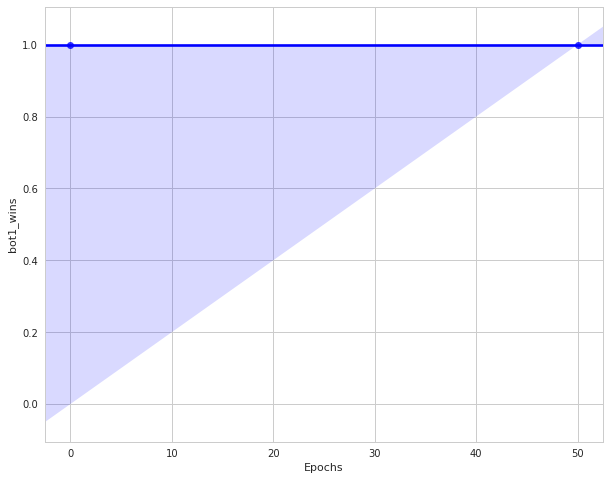

In [18]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(figsize=(10,8))
ax = sns.regplot(data=win_trace_50_samples.reset_index(), x='index', y='bot1', color='b')
ax.set(xlabel='Epochs', ylabel='bot1_wins')
plt.show()

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


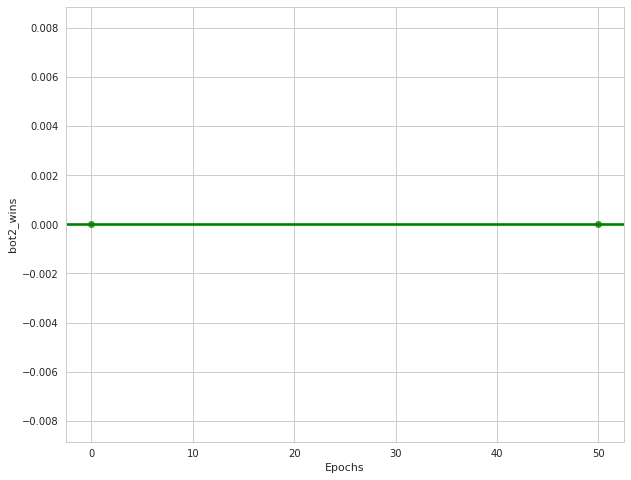

In [19]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(figsize=(10,8))
ax = sns.regplot(data=win_trace_50_samples.reset_index(), x='index', y='bot2', color='g')
ax.set(xlabel='Epochs', ylabel='bot2_wins')
plt.show()